# RESUMO

## Sobre o projeto

Será feita uma análise sobre os dados da Covid-19 no Brasil. Através dessa análise poderemos fazer previsões sobre os números futuros de casos e óbitos pela doença no país.

A análise será feita sobre os dados da Covid-19 no Brasil extraídos diretamente do site https://covid.saude.gov.br/, administrado pelo Ministério da saúde.

Os dados analisados foram atualizados em 14/01/2021.

# IMPORTS E FUNÇÕES AUXILIARES

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import r2_score
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

import plotly.io as pio
pio.renderers

pio.renderers.default = "svg"

### Funções auxiliares

#### plotagem seasonal decompose

In [2]:
def plot_seasonal_decompose(dataset, data, period, titulo, model):
    decomposicao = seasonal_decompose(dataset.set_index(data), period = period, model = model)
    figure = decomposicao.plot();

    figure.suptitle(titulo, fontsize = 22, x = .33, y = 1.05)

    figure.set_size_inches((15,6))
    figure.axes[0].set_title('Observados', fontsize = 14)
    figure.axes[0].grid(linestyle='-', linewidth=1.5)
    figure.axes[0].set_ylabel('')

    figure.axes[1].set_title('Tendência', fontsize = 14)
    figure.axes[1].grid(linestyle='-', linewidth=1.5)
    figure.axes[1].set_ylabel('')

    figure.axes[2].set_title('Sazonalidade', fontsize = 14)
    figure.axes[2].grid(linestyle='-', linewidth=1.5)
    figure.axes[2].set_ylabel('')

    figure.axes[3].set_title('Resíduos', fontsize = 14)
    figure.axes[3].grid(linestyle='-', linewidth=1.5)
    figure.axes[3].set_ylabel('')
    figure.axes[3].set_xlabel('Data', fontsize = 14, labelpad = 20);
    

#### plotagem série temporal com linha

In [3]:
def plot_st_linhas(dataframe, xline, yline, xlabel, ylabel, titulo):
    fig1 = px.line(x = dataframe[xline], y = dataframe[yline],
                  labels=dict(x=xlabel, y=ylabel))
    fig1.update_layout(title = titulo)
    fig1.show();

#### plotagem série temporal com linha e barras

In [4]:
def plot_st_linhas_barras(dataframe, xline, yline, xbar, ybar, xlabel, ylabel, titulo):
    fig1 = px.bar(x = dataframe[xbar], y = dataframe[ybar],
                  labels=dict(x=xlabel, y=ylabel))
    fig1.add_trace(go.Line(x = dataframe[xline], y = dataframe[yline], showlegend = False))
    fig1.update_layout(title = titulo)
    fig1.show();

#### plotagem série temporal linha, barra, com média móvel

In [5]:
def plot_st_com_media_movel(dataframe, xlinha, ylinha, xbarra, ybarra, media_movel, xlabel, ylabel, 
                       nome_legenda_1, titulo):
    fig1 = px.bar(x = dataframe[xbarra], y = dataframe[ybarra],
                  labels=dict(x=xlabel, y=ylabel))
    fig1.add_trace(go.Line(x = dataframe[xlinha], y = dataframe[ylinha], showlegend = True, 
                           name = nome_legenda_1))
    fig1.add_trace(go.Line(x = dataframe[xlinha], y = dataframe[media_movel], showlegend = True, 
                           name = 'média móvel'))
    fig1.update_layout(title = titulo, 
                      legend=dict(
                      title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"))
    fig1.show();

# CARREGAMENTO DOS DADOS

In [6]:
dados = pd.read_csv('dados/HIST_PAINEL_COVIDBR_14fev2021.csv', sep = ';')
#dados = pd.read_csv('dados/HIST_PAINEL_COVIDBR_01mar2021.csv', sep = ';')

In [7]:
dados.head(3)

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125.0,0,0,0,0,NaN,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,1,0,0,NaN,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,0,0,NaN,NaN,NaN


Verificamos pela coluna "data" que as atualizações são diárias (apesar de ainda não sabermos se houve algum dia sem atualização).

# DESCRIÇÃO DOS DADOS E ALTERAÇÃO DE TIPOS

### Descrição dos dados

In [8]:
# número de linhas e colunas
print(f'Número de linhas: {dados.shape[0]}')
print(f'Número de colunas: {dados.shape[1]}')

Número de linhas: 1827045
Número de colunas: 17


In [9]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827045 entries, 0 to 1827044
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   regiao                  object 
 1   estado                  object 
 2   municipio               object 
 3   coduf                   int64  
 4   codmun                  float64
 5   codRegiaoSaude          float64
 6   nomeRegiaoSaude         object 
 7   data                    object 
 8   semanaEpi               int64  
 9   populacaoTCU2019        float64
 10  casosAcumulado          int64  
 11  casosNovos              int64  
 12  obitosAcumulado         int64  
 13  obitosNovos             int64  
 14  Recuperadosnovos        float64
 15  emAcompanhamentoNovos   float64
 16  interior/metropolitana  float64
dtypes: float64(6), int64(6), object(5)
memory usage: 237.0+ MB


In [10]:
# verificação de dados nulos em cada coluna
dados.isna().sum()

regiao                          0
estado                        358
municipio                   16795
coduf                           0
codmun                       9970
codRegiaoSaude              16795
nomeRegiaoSaude             16795
data                            0
semanaEpi                       0
populacaoTCU2019             6825
casosAcumulado                  0
casosNovos                      0
obitosAcumulado                 0
obitosNovos                     0
Recuperadosnovos          1826741
emAcompanhamentoNovos     1826741
interior/metropolitana      16795
dtype: int64

In [11]:
# tipos de dados
dados.dtypes

regiao                     object
estado                     object
municipio                  object
coduf                       int64
codmun                    float64
codRegiaoSaude            float64
nomeRegiaoSaude            object
data                       object
semanaEpi                   int64
populacaoTCU2019          float64
casosAcumulado              int64
casosNovos                  int64
obitosAcumulado             int64
obitosNovos                 int64
Recuperadosnovos          float64
emAcompanhamentoNovos     float64
interior/metropolitana    float64
dtype: object

### Alteração do tipo da coluna "data"

Essa alteração é primordial para que possamos trabalhar com as datas para nossas análises e previsões.

In [12]:
dados.data = pd.to_datetime(dados.data)

In [13]:
dados.dtypes

regiao                            object
estado                            object
municipio                         object
coduf                              int64
codmun                           float64
codRegiaoSaude                   float64
nomeRegiaoSaude                   object
data                      datetime64[ns]
semanaEpi                          int64
populacaoTCU2019                 float64
casosAcumulado                     int64
casosNovos                         int64
obitosAcumulado                    int64
obitosNovos                        int64
Recuperadosnovos                 float64
emAcompanhamentoNovos            float64
interior/metropolitana           float64
dtype: object

# ESTATÍSTICA DESCRITIVA E ANÁLISE DAS SÉRIES TEMPORAIS

## Números das últimas 24 horas registradas no dataset

In [14]:
brasil = dados[dados['regiao'] == 'Brasil']

Alguns números do último dia de registro:

In [15]:
print('Número acumulado de casos registrado no último dia: ', brasil['casosAcumulado'].iloc[-1])
print('Número de novos casos registrados no último dia: ', brasil['casosNovos'].iloc[-1])
print('Número acumulado de óbitos registrado no último dia: ', brasil['obitosAcumulado'].iloc[-1])
print('Número de novos óbitos registrados no último dia: ', brasil['obitosNovos'].iloc[-1])
print('Número acumulado de recuperados registrado no último dia: ', brasil['Recuperadosnovos'].iloc[-1])
print('Número de novos infectados em acompanhamento registrado no último dia: ', brasil['emAcompanhamentoNovos'].iloc[-1])
print('Número de óbitos por hora no último dia:', (brasil["obitosNovos"].iloc[-1]/24).round(2))

Número acumulado de casos registrado no último dia:  9834513
Número de novos casos registrados no último dia:  24759
Número acumulado de óbitos registrado no último dia:  239245
Número de novos óbitos registrados no último dia:  713
Número acumulado de recuperados registrado no último dia:  8745424.0
Número de novos infectados em acompanhamento registrado no último dia:  849844.0
Número de óbitos por hora no último dia: 29.71


## Evolução dos casos ativos no Brasil:

C:\Users\Vinicius Moraes\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




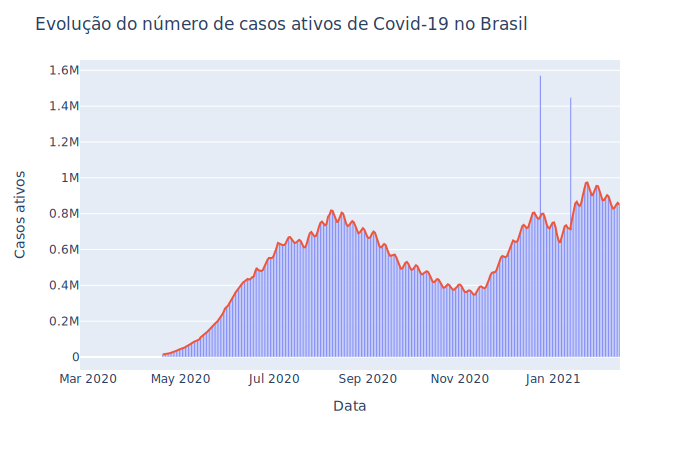

In [16]:
fig1 = px.bar(x = brasil['data'], y = brasil['emAcompanhamentoNovos'],
              labels=dict(x='Data', y='Casos ativos'))
fig1.add_trace(go.Line(x = brasil['data'], y = brasil['emAcompanhamentoNovos'], showlegend = False))
fig1.update_layout(title = 'Evolução do número de casos ativos de Covid-19 no Brasil');
fig1.show();

Observando o gráfico acima, podemos perceber que há 2 valores discrepantes: o do dia 24/12/2020 e do dia 13/01/2021. Vamos verificar:

In [17]:
discrepante_dezembro = brasil[brasil['data'] == '24-12-2020']
print('Valor discrepante de Dezembro:')
display(discrepante_dezembro)
discrepante_janeiro = brasil[brasil['data'] == '13-1-2021']
print('Valor discrepante de Janeiro:')
display(discrepante_janeiro)

Valor discrepante de Dezembro:


,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
303,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-12-24,52,210147125.0,7425593,60076,190006,786,6448740.0,785223.0,NaN
304,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-12-24,52,210147125.0,7425593,0,190006,0,6449822.0,785765.0,NaN


Valor discrepante de Janeiro:


,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
324,Brasil,NaN,NaN,76,NaN,NaN,NaN,2021-01-13,2,210147125.0,8256536,60899,205964,1274,7277195.0,713752.0,NaN
325,Brasil,NaN,NaN,76,NaN,NaN,NaN,2021-01-13,2,210147125.0,8256536,0,205964,0,7316944.0,733628.0,NaN


Como verificamos, há dois registros nos dias citados. Mas as colunas "casosAcumulado" e "obitosAcumulado" não tem alteração, assim como não há registros de "casosNovos" e "obitosNovos". Os valores discrepantes existem no gráfico pois são somados os dois valores da coluna "emAcompanhamentoNovos". 

Sendo assim, essas linhas serão excluídas, pois não vão influenciar nos números que queremos.

In [18]:
# exclusão das linhas
brasil.drop(index = [304, 325], axis = 0, inplace = True)

# renumerando o índice após retirar 2 linhas
brasil.reset_index(drop = True, inplace = True)

Podemos verificar novamente a evolução do número de casos ativos:

C:\Users\Vinicius Moraes\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




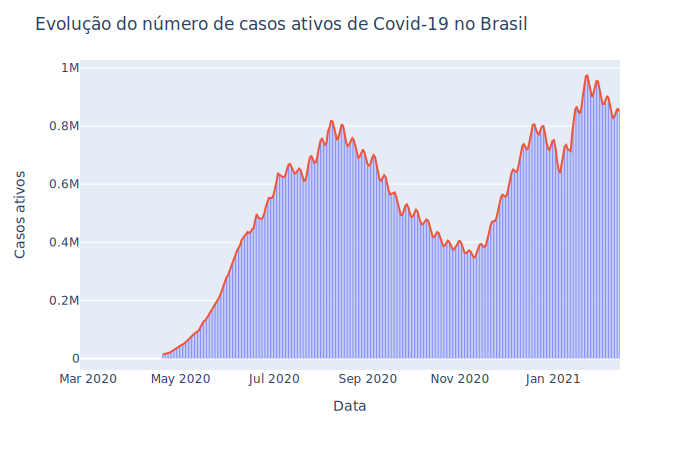

In [19]:
fig1 = px.bar(x = brasil['data'], y = brasil['emAcompanhamentoNovos'],
              labels=dict(x='Data', y='Casos ativos'))
fig1.add_trace(go.Line(x = brasil['data'], y = brasil['emAcompanhamentoNovos'], showlegend = False))
fig1.update_layout(title = 'Evolução do número de casos ativos de Covid-19 no Brasil')
fig1.show();

A série temporal acima nos mostra que houve uma queda do número de casos ativos após um pico entre os dias 8 e 9 de Agosto, tendo seu menor valor entre os dias 10 e 11 de Novembro.

Após uma nova subida e leve queda em 06/01/2021, temos em 24/01/2021 o maior pico de casos ativos desde o início da pandemia.

Tudo isso nos mostra que o verão brasileiro e as festas de fim de ano parecem ter influenciado nas aglomerações e na consequente maior disseminação do vírus.

Vamos fazer a decomposição da série temporal para encontrarmos a tendência, a sazonalidade, 

In [20]:
#decomposicao = seasonal_decompose(brasil.set_index('data'), period = 12)

Não conseguimos executar a decomposição da série temporal, pois há valores nulos na coluna. Vamos verificar os índices desses valores nulos.

In [21]:
brasil['emAcompanhamentoNovos'][brasil['emAcompanhamentoNovos'].isnull() == True].index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53],
           dtype='int64')

Para nossa sorte, os valores nulos estão em sequência até o índice 53. Faremos então a decomposição a partir do primeiro dado "não nulo".

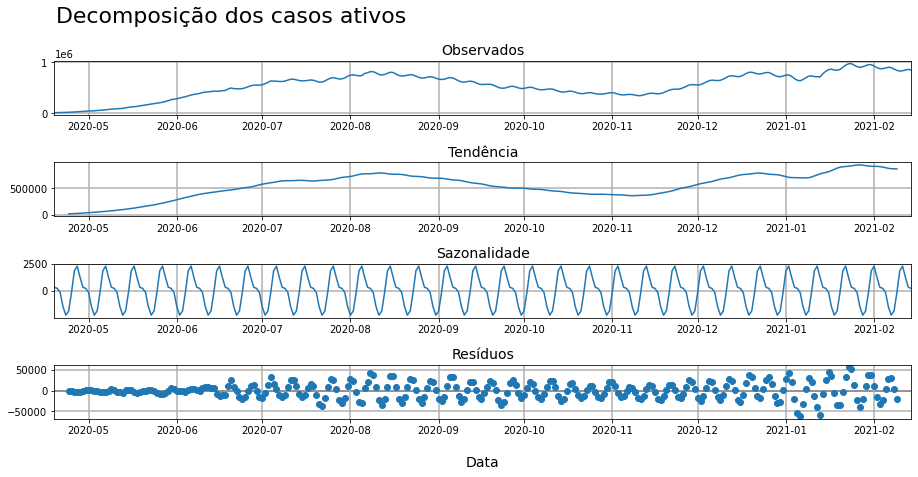

In [22]:
brasil_casos_ativos = brasil[['data', 'emAcompanhamentoNovos']][54:]
plot_seasonal_decompose(brasil_casos_ativos, 'data', 10, 'Decomposição dos casos ativos', 'additive')

## Evolução de novos registros de óbito por Covid-19 no Brasil:

C:\Users\Vinicius Moraes\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




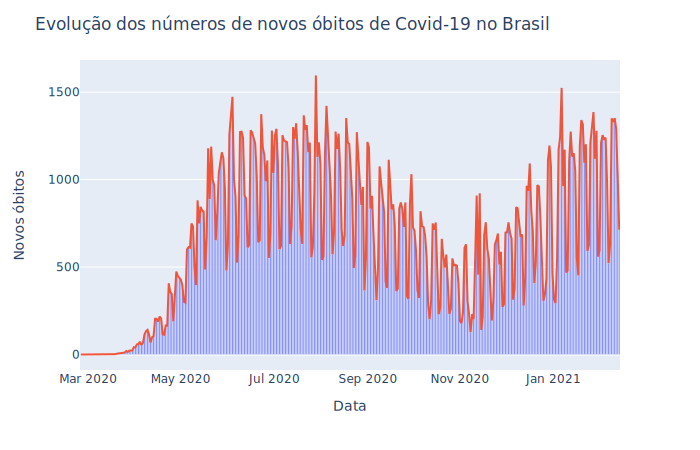

In [23]:
plot_st_linhas_barras(brasil, 'data', 'obitosNovos', 'data', 'obitosNovos', 'Data', 'Novos óbitos',
                 'Evolução dos números de novos óbitos de Covid-19 no Brasil')

A série temporal dos números diários de óbitos por Covid-19 nos mostra que, apesar de alguns picos, tivemos queda nesses números a partir do mês de Agosto, tendo em 28/11/2020 seu menor número (128). A partir disso podemos notar o início de uma tendência de aumento gerada, ao que parece, pelo início do verão brasileiro e pelas festas de fim de ano.

Apesar de tendência de forte alta causada a partir do fim de 2020, podemos observar que o dia com maior número de registro de óbitos foi em 29/07/2020.

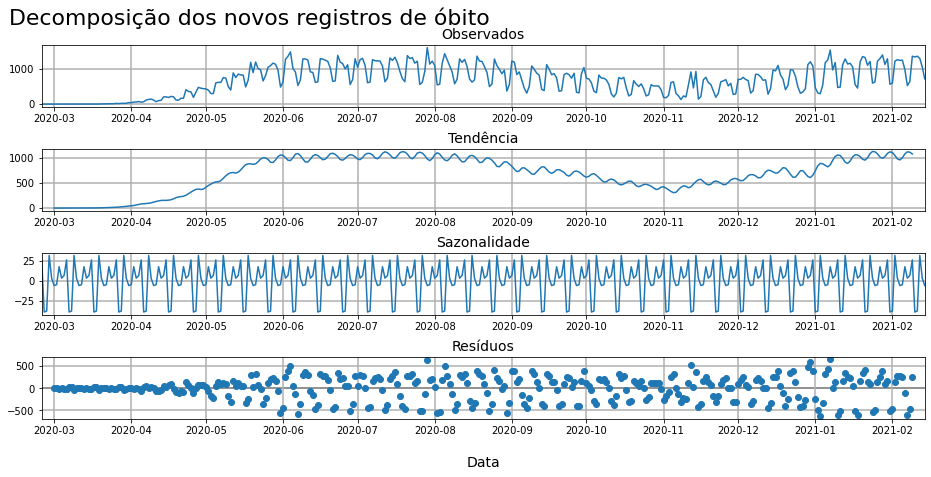

In [24]:
brasil_obitos_novos = brasil[['data', 'obitosNovos']]
plot_seasonal_decompose(brasil_obitos_novos, 'data', 10, 'Decomposição dos novos registros de óbito', 
                        'additive')

Vamos encontrar a média móvel:

In [25]:
# média móvel de óbitos
brasil_obitos_novos['media_movel'] = brasil_obitos_novos.obitosNovos.rolling(7).mean()

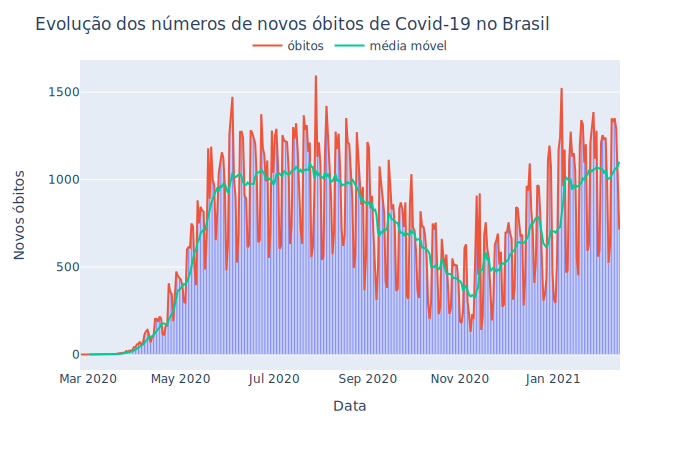

In [26]:
plot_st_com_media_movel(brasil_obitos_novos, 'data', 'obitosNovos', 'data', 'obitosNovos', 'media_movel', 
                   'Data', 'Novos óbitos', 'óbitos', 
                   'Evolução dos números de novos óbitos de Covid-19 no Brasil')

Com a linha da média móvel de 7 dias, conseguimos suavizar o ruído da série temporal.

A média móvel parece indicar, ainda, uma tendência de aumento do número de óbitos de Covid-19 para os próximos dias.

## Evolução de novos casos de Covid-19 no Brasil:

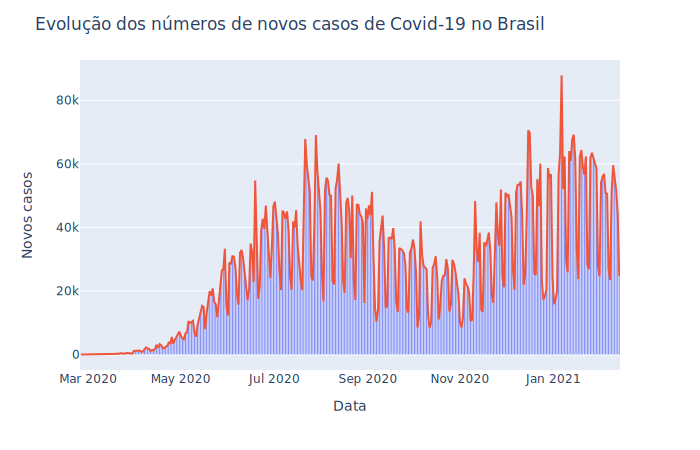

In [27]:
plot_st_linhas_barras(brasil, 'data', 'casosNovos', 'data', 'casosNovos', 'Data', 'Novos casos',
                 'Evolução dos números de novos casos de Covid-19 no Brasil')

Temos acima a série temporal dos novos casos diários de Covid-19. 

Podemos perceber a alta do número de casos entre o início dos registros no Brasil, em março, até o fim de Julho e início de Agosto, após seus dias com maiores picos. Após isso, uma queda até o início de Novembro, onde se inicia outra forte subida no número de novos casos diários, atingindo o maior pico no nesse número. no dia 07/01/2021, com 87843 novos infectados.

Observando o registros após 07/01, parece haver uma tendência de queda nos números. Podemos utilizar a média móvel para fazer uma melhor análise.

In [28]:
brasil_casos_novos = brasil[['data', 'casosNovos']]
brasil_casos_novos['media_movel'] = brasil_casos_novos.casosNovos.rolling(7).mean()

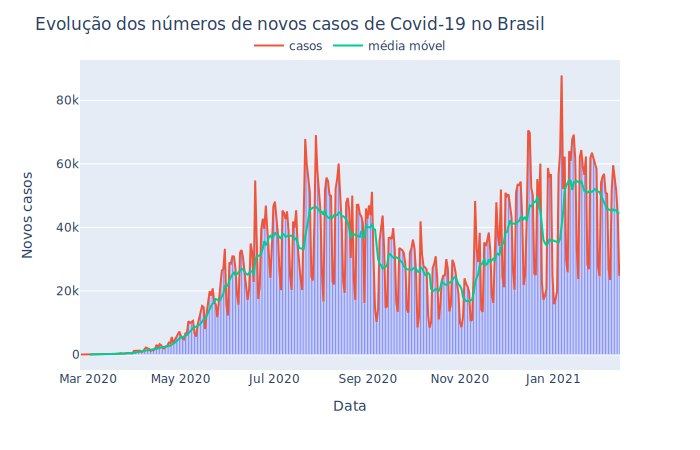

In [29]:
plot_st_com_media_movel(brasil_casos_novos, 'data', 'casosNovos', 'data', 'casosNovos', 'media_movel', 
                   'Data', 'Novos casos', 'casos', 
                   'Evolução dos números de novos casos de Covid-19 no Brasil')

Com a média móvel dos novos casos de Covid-19, podemos verificar melhor o que parece ser uma tendência de queda no números diários desses novos registros.

Podemos também fazer a decomposição da série temporal para visualizar, separadamente, a sazonalidade e a tendência.

Antes, vamos verificar os dados nulos.

In [30]:
brasil_casos_novos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         356 non-null    datetime64[ns]
 1   casosNovos   356 non-null    int64         
 2   media_movel  350 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 8.5 KB


Temos dados nulos apenas na coluna de média móvel (obviamente, nas 7 primeiras linhas, devido à janela de tempo definida).

In [31]:
brasil_casos_novos = brasil_casos_novos[['data', 'casosNovos']]

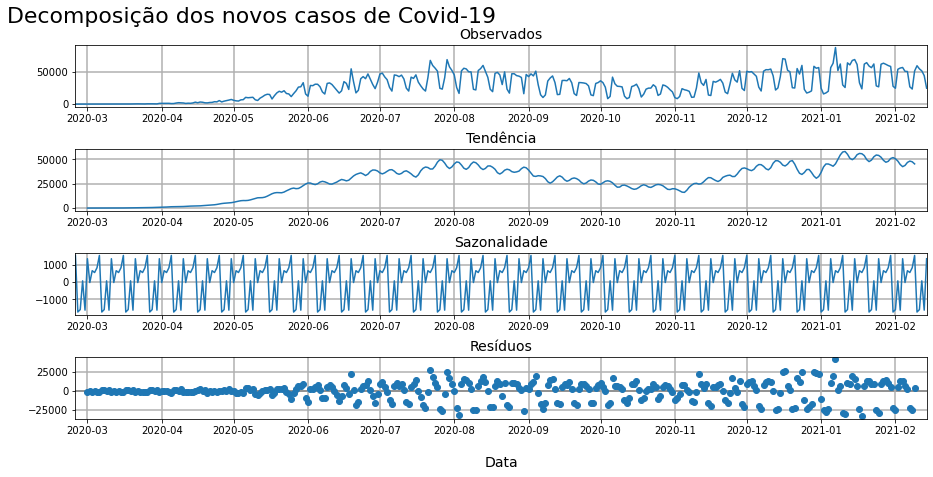

In [32]:
plot_seasonal_decompose(brasil_casos_novos, 'data', 10, 'Decomposição dos novos casos de Covid-19', 
                        'additive')

## Taxa de mortalidade no Brasil ao longo da pandemia:

In [33]:
brasil['taxaMortalidade'] = ((brasil['obitosAcumulado'] / brasil['casosAcumulado']) * 100).round(1)

Vamos verificar a série temporal da taxa de mortalidade durante a pandemia:

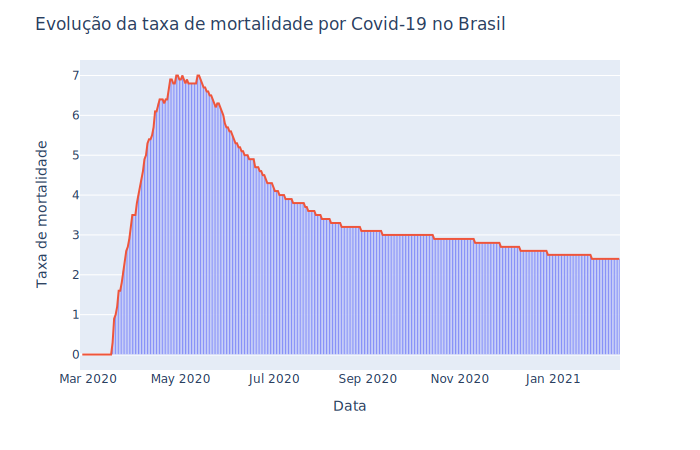

In [34]:
plot_st_linhas_barras(brasil, 'data', 'taxaMortalidade', 'data', 'taxaMortalidade', 'Data', 
                      'Taxa de mortalidade', 'Evolução da taxa de mortalidade por Covid-19 no Brasil')

O gráfico nos mostra que a taxa de mortalidade teve seus maiores valores logo no início da pandemia, com queda a partir da metade de Março.

Essa queda pode ter sido causada por alguns fatores, como, por exemplo, a utilização de remédios que não se sabia que poderiam auxiliar no tratamento, como antibióticos e corticóides.

## Autocorrelação

A autocorrelação nos mostrará a correlação entre o dia atual e os dias anteriores e qual a "força" de sua influência no número de casos de COVID-19 mais atual, onde cada lag representa 1 dia.

Para criarmos as previsões de casos de COVID-19 utilizando as séries temporais de uma variável, é necessário que haja essa correlação. Caso contrário, os números passados não "explicarão" essas previsões corretamente e, nesse caso, poderíamos utilizar o valor do dia anterior para tentar criar essa previsão. Mas essa forma limita nossas possibilidades de resultado.

Autocorrelação de novos casos diários

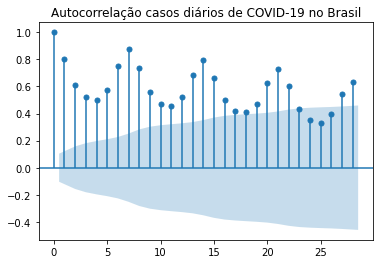

In [35]:
plot_acf(brasil['casosNovos'], lags = 28, title = 'Autocorrelação casos diários de COVID-19 no Brasil');

Autocorrelação de óbitos diários

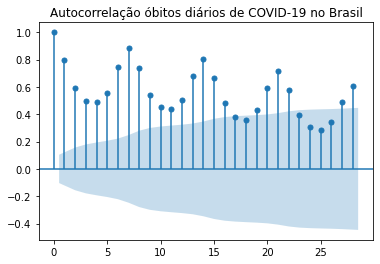

In [36]:
plot_acf(brasil['obitosNovos'], lags = 28, 
         title = 'Autocorrelação óbitos diários de COVID-19 no Brasil');

A autocorrelação de casos diários e óbitos diários seguem ciclos de 7 dias, tendo maiores valores no início e no fim desses ciclos.

## Análises dos estados do Sudeste

In [37]:
rj = dados[(dados['estado'] == 'RJ') & (dados['municipio'].isna() == True) & (dados['codmun'].isna() == True)]
sp = dados[(dados['estado'] == 'SP') & (dados['municipio'].isna() == True) & (dados['codmun'].isna() == True)]
es = dados[(dados['estado'] == 'ES') & (dados['municipio'].isna() == True) & (dados['codmun'].isna() == True)]
mg = dados[(dados['estado'] == 'MG') & (dados['municipio'].isna() == True) & (dados['codmun'].isna() == True)]

### SP

#### Novos casos e média móvel

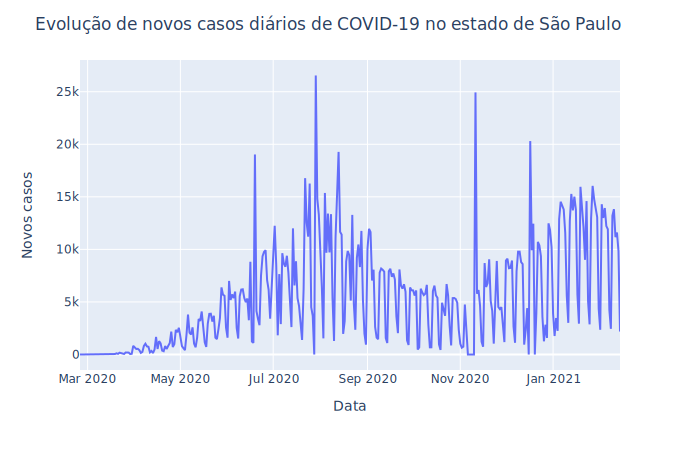

In [38]:
plot_st_linhas(sp, 'data', 'casosNovos', 'Data', 'Novos casos', 
                   'Evolução de novos casos diários de COVID-19 no estado de São Paulo')

Média móvel:

In [39]:
sp_casos_novos = sp[['data', 'casosNovos']]
sp_casos_novos['media_movel'] = sp_casos_novos.casosNovos.rolling(7).mean()

C:\Users\Vinicius Moraes\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




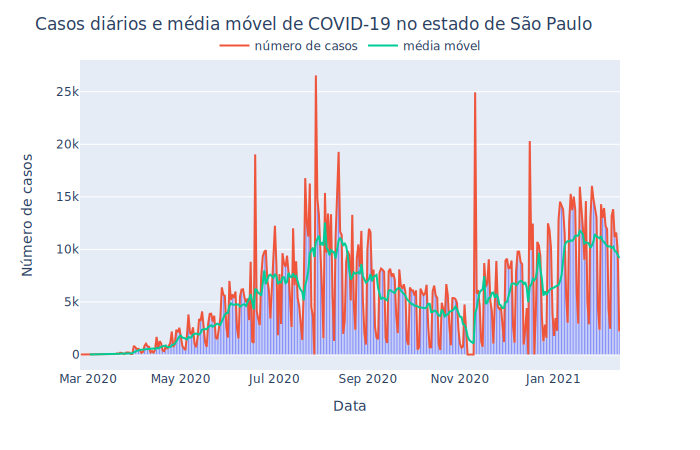

In [40]:
plot_st_com_media_movel(sp_casos_novos,'data','casosNovos','data','casosNovos','media_movel','Data',
                        'Número de casos','número de casos',
                        'Casos diários e média móvel de COVID-19 no estado de São Paulo');

A média móvel do número de casos diários de COVID-19 parece nos apresentar uma tendência de queda nesse mês de Janeiro.

#### Número de casos acumulado

In [41]:
sp_casos_acumulado = sp[['data', 'casosAcumulado']]

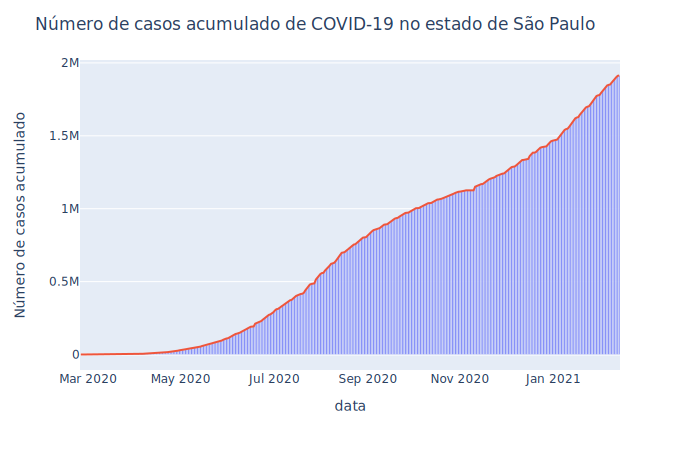

In [42]:
plot_st_linhas_barras( sp_casos_acumulado,
    'data',
    'casosAcumulado',
    'data',
    'casosAcumulado',
    'data',
    'Número de casos acumulado',
    'Número de casos acumulado de COVID-19 no estado de São Paulo');

O aumento do número de casos acumulado seguiu sem que nenhum mês tenha tido uma alta muito significativa.

Podemos observar também que, no início de Novembro, houve uma tendência de estabilização nesse número acumulado, porém isso durou poucos dias. Houve novo disparo na linha com um pouco mais de força a partir de Janeiro, ao que parece, pelas festas e encontros no fim do ano de 2020.

#### Óbitos e média móvel

In [43]:
sp_obitos_novos = sp[['data', 'obitosNovos']]
sp_obitos_novos['media_movel'] = sp_obitos_novos['obitosNovos'].rolling(7).mean()

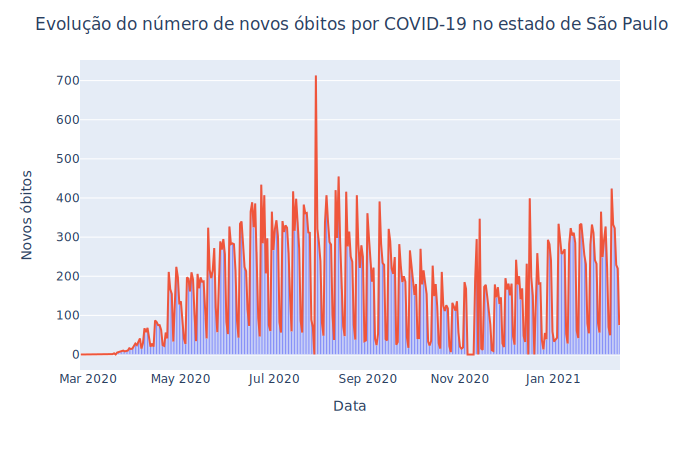

In [44]:
plot_st_linhas_barras(sp_obitos_novos,
    'data',
    'obitosNovos',
    'data',
    'obitosNovos',
    'Data',
    'Novos óbitos',
    'Evolução do número de novos óbitos por COVID-19 no estado de São Paulo')

O estado de São Paulo teve queda no número diário de óbitos a partir de Agosto, após seu pior dia na pandemia, 29/07/2020, onde 713 pessoas faleceram em decorrência da doença. A partir de Novembro temos um novo aumento nesse número até os dias atuais.

Vamos utilizar a média móvel para tentar verificar se a tendência ainda é de alta:

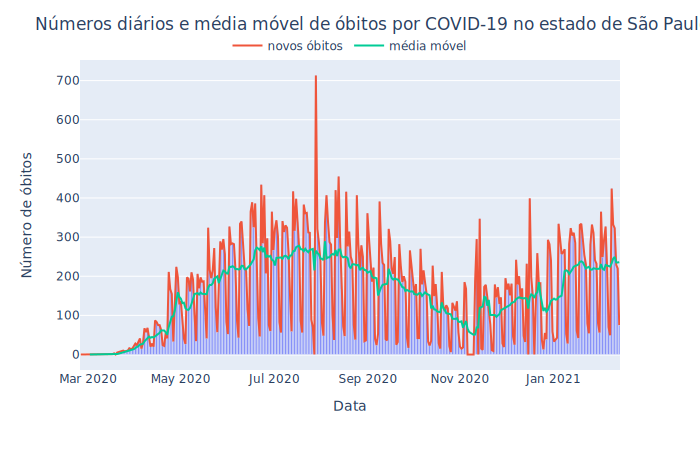

In [45]:
plot_st_com_media_movel(sp_obitos_novos,
    'data',
    'obitosNovos',
    'data',
    'obitosNovos',
    'media_movel',
    'Data',
    'Número de óbitos',
    'novos óbitos',
   ' Números diários e média móvel de óbitos por COVID-19 no estado de São Paulo');

A média móvel nos mostra que o número de óbitos diário por COVID-19 pode estar se estabilizando no estado de São Paulo. Isso deve ser conferido nas próximas semanas. 

#### Taxa de mortalidade

In [46]:
sp['taxaMortalidade'] = ((sp['obitosAcumulado'] / sp['casosAcumulado']) * 100).round(1)

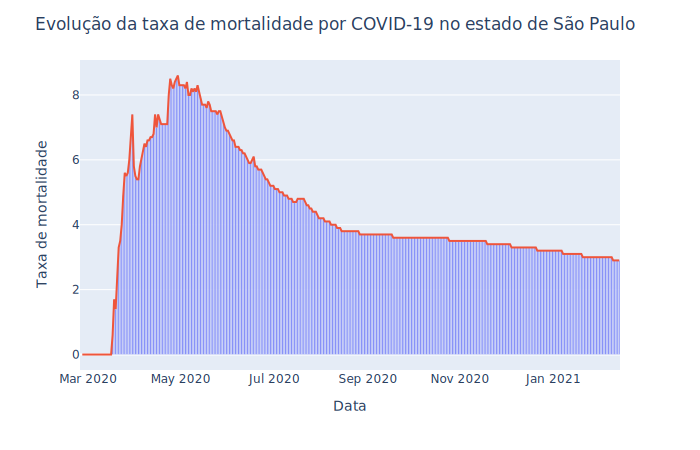

In [47]:
plot_st_linhas_barras(sp, 'data', 'taxaMortalidade', 'data', 'taxaMortalidade', 'Data', 
                      'Taxa de mortalidade', 
                      'Evolução da taxa de mortalidade por COVID-19 no estado de São Paulo')

A taxa de mortalidade por COVID no estado de São Paulo teve poucos e pequenos aumentos desde que iniciou sua queda, no início de Abril. 

#### Autocorrelação

Autocorrelação de novos casos diários

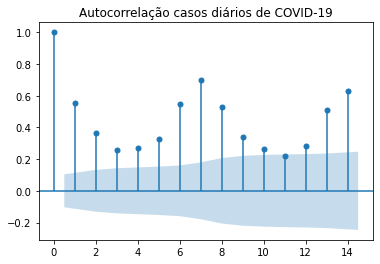

In [48]:
plot_acf(sp_casos_novos['casosNovos'], lags = 14, title = 'Autocorrelação casos diários de COVID-19');

O gráfico acima nos mostra alta correlação com os dias anteriores nos novos casos diários de COVID-19 no estado de São Paulo. Podemos ver que a correlação está em ciclos de 7 dias, tendo correlação maior nos dias iniciais e finais desses ciclos.

Autocorrelação de óbitos diários

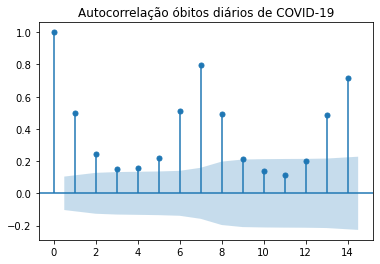

In [49]:
plot_acf(sp_obitos_novos['obitosNovos'], lags = 14, title = 'Autocorrelação óbitos diários de COVID-19');

A autocorrelação dos óbitos diários também se apresenta em ciclos, sendo maior no início e no fim dos ciclos, sendo que no sétimo dia a correlação chega a 0.80.

### RJ

#### Novos casos e média móvel

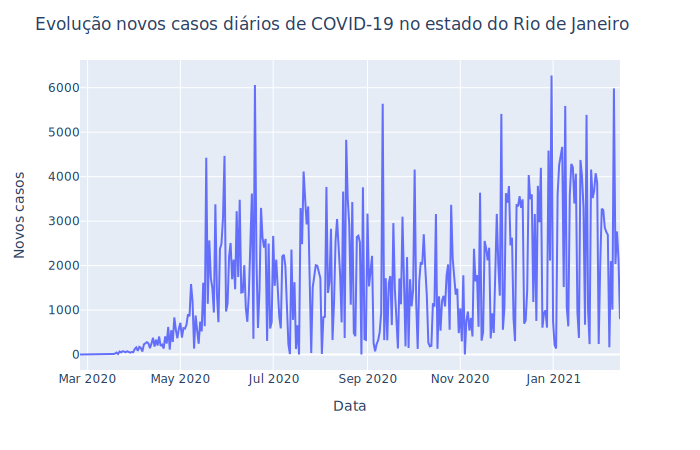

In [50]:
plot_st_linhas(rj, 'data', 'casosNovos', 'Data', 'Novos casos', 
               'Evolução novos casos diários de COVID-19 no estado do Rio de Janeiro')

Média móvel:

In [51]:
rj_casos_novos = rj[['data', 'casosNovos']]
rj_casos_novos['media_movel'] = rj_casos_novos.casosNovos.rolling(7).mean()

C:\Users\Vinicius Moraes\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




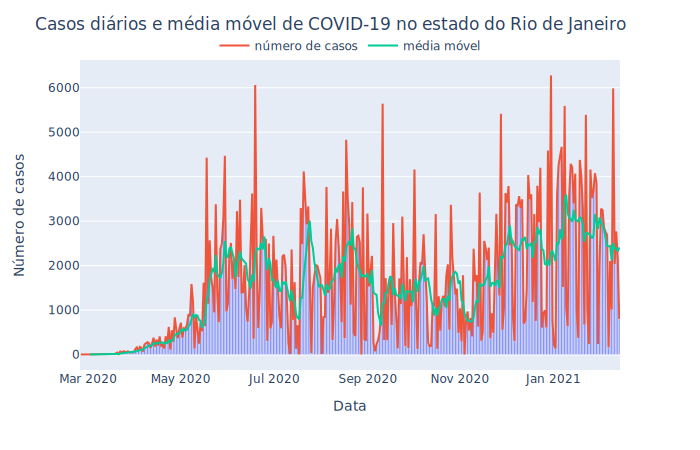

In [52]:
plot_st_com_media_movel(rj_casos_novos,'data','casosNovos','data','casosNovos','media_movel','Data',
                        'Número de casos','número de casos',
                        'Casos diários e média móvel de COVID-19 no estado do Rio de Janeiro');

Os casos diários de COVID-19 no estado do Rio de Janeiro apresentaram forte alta a partir de Novembro. 

A partir do fim de Janeiro/início de Fevereiro houve uma queda nesses númerose uma pequena alta a partir de 09/02/2021, que talvez não signifique uma tendência de nova alta. A conferir.

#### Número de casos acumulado

In [53]:
rj_casos_acumulado = rj[['data', 'casosAcumulado']]

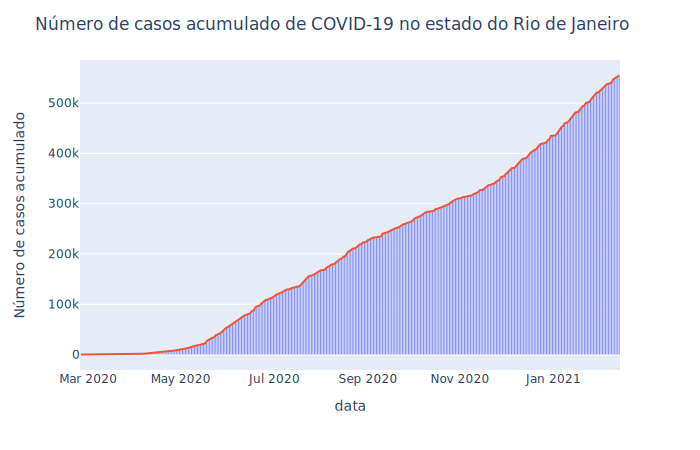

In [54]:
plot_st_linhas_barras( rj_casos_acumulado,
    'data',
    'casosAcumulado',
    'data',
    'casosAcumulado',
    'data',
    'Número de casos acumulado',
    'Número de casos acumulado de COVID-19 no estado do Rio de Janeiro');

O número de casos acumulado manteve seu aumento em uma velocidade praticamente igual durante todo o período. 

Assim como no estado de São Paulo, esse número pareceu iniciar uma estabilização a partir do fim de outubro e os primeiros 10 dias de Novembro, mas essa tendência não se confirmou.

#### Óbitos e média móvel

In [55]:
rj_obitos_novos = rj[['data', 'obitosNovos']]
rj_obitos_novos['media_movel'] = rj_obitos_novos['obitosNovos'].rolling(7).mean()

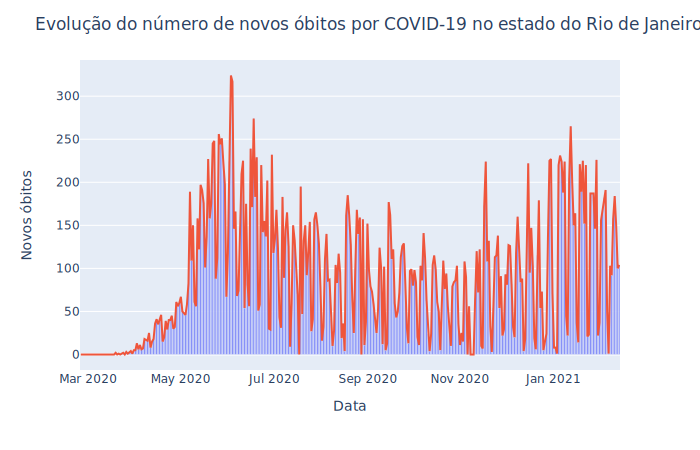

In [56]:
plot_st_linhas_barras(rj_obitos_novos,
    'data',
    'obitosNovos',
    'data',
    'obitosNovos',
    'Data',
    'Novos óbitos',
    'Evolução do número de novos óbitos por COVID-19 no estado do Rio de Janeiro')

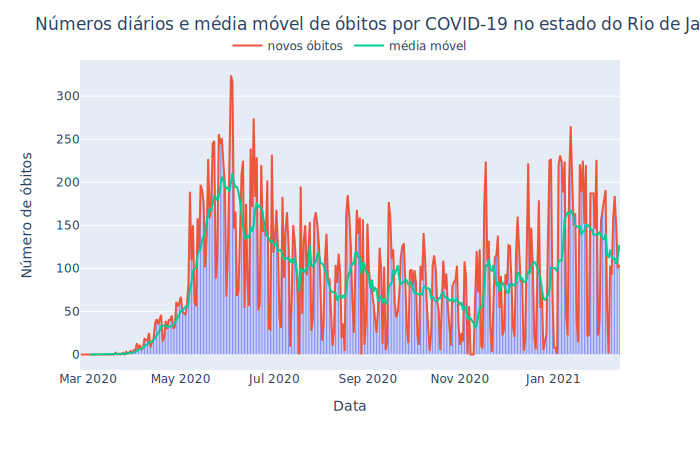

In [57]:
plot_st_com_media_movel(rj_obitos_novos,
    'data',
    'obitosNovos',
    'data',
    'obitosNovos',
    'media_movel',
    'Data',
    'Número de óbitos',
    'novos óbitos',
   ' Números diários e média móvel de óbitos por COVID-19 no estado do Rio de Janeiro');

O número de óbitos por COVID-19 no estado do Rio de Janeiro apresentou queda a partir de Maio. A partir de Novembro, nova alta. 

Entre 27/12/2020 e 14/01/2021 houve um aumento de quase 3x nesse número. Após, uma nova queda até o dia 12/02/2021, onde temos o que parece ser uma nova tendência de alta. A conferir nas próximas semanas.

#### Taxa de mortalidade

In [58]:
rj['taxaMortalidade'] = ((rj['obitosAcumulado'] / rj['casosAcumulado']) * 100).round(1)

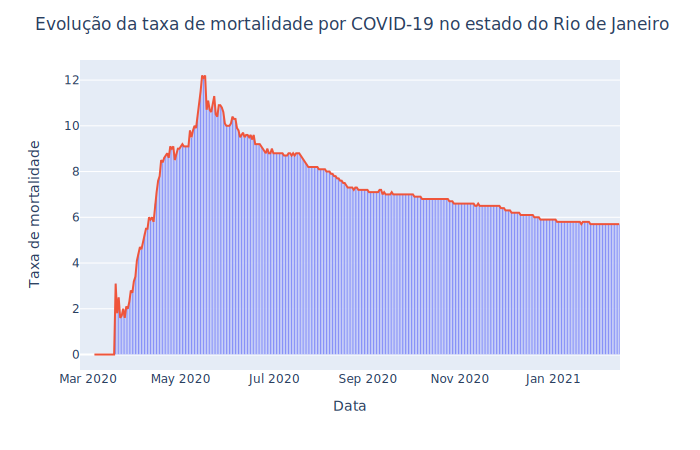

In [59]:
plot_st_linhas_barras(rj, 'data', 'taxaMortalidade', 'data', 'taxaMortalidade', 'Data', 
                      'Taxa de mortalidade', 
                      'Evolução da taxa de mortalidade por COVID-19 no estado do Rio de Janeiro')

A taxa de mortalidade por COVID-19 se manteve em ritmo de queda desde Maio, até os dias atuais. O que chama a atenção é que esse índice, atualmente, é de 5.7%, quase o dobro do estado de São Paulo, que estça em 2.9% atualmente.

#### Autocorrelação

Autocorrelação de novos casos diários

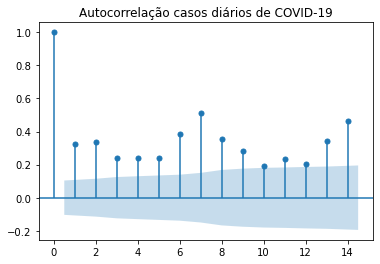

In [60]:
plot_acf(rj_casos_novos['casosNovos'], lags = 14, title = 'Autocorrelação casos diários de COVID-19');

A autocorrelação nos novos casos diários no estado do RJ se mostra menos forte nos ciclos de 7 dias em comparação com o estado de SP.

Difere também na intensidade da correlação nos dias representados pelos lags.

Autocorrelação de óbitos diários

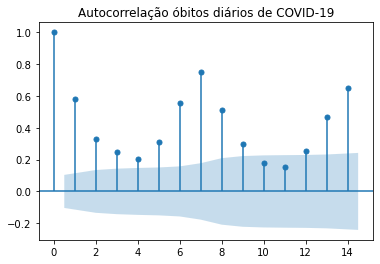

In [61]:
plot_acf(rj_obitos_novos['obitosNovos'], lags = 14, title = 'Autocorrelação óbitos diários de COVID-19');

### ES

#### Novos casos e média móvel

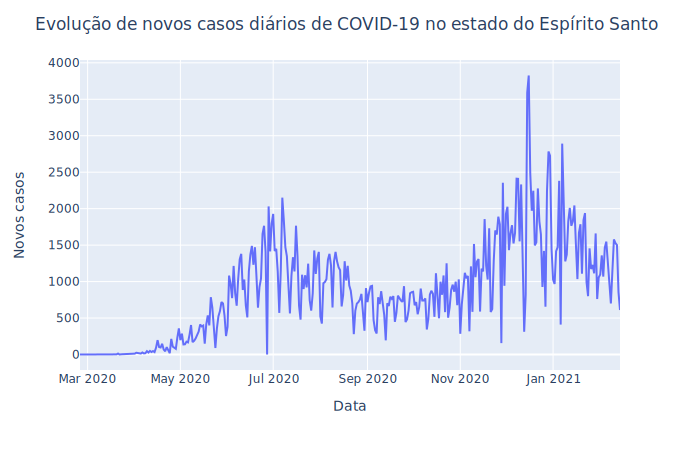

In [62]:
plot_st_linhas(es, 'data', 'casosNovos', 'Data', 'Novos casos', 
               'Evolução de novos casos diários de COVID-19 no estado do Espírito Santo')

Média móvel:

In [63]:
es_casos_novos = es[['data', 'casosNovos']]
es_casos_novos['media_movel'] = es_casos_novos.casosNovos.rolling(7).mean()

C:\Users\Vinicius Moraes\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




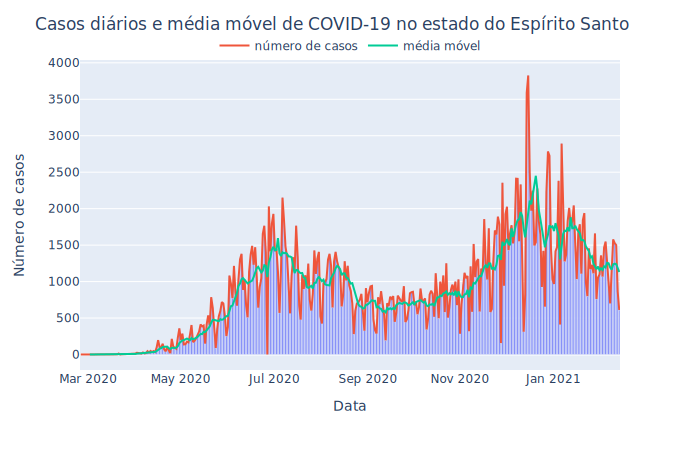

In [64]:
plot_st_com_media_movel(es_casos_novos,'data','casosNovos','data','casosNovos','media_movel','Data',
                        'Número de casos','número de casos',
                        'Casos diários e média móvel de COVID-19 no estado do Espírito Santo');

Diferentemente dos estado de SP e RJ, temos menor variação nos números diários de casos de COVID-19 no estado do Espírito Santo. Mas o padrão se mantém o mesmo em relação à nova alta na média móvel a partir de Novembro, com queda a partir da metade de Janeiro.

#### Número de casos acumulado

In [65]:
es_casos_acumulado = es[['data', 'casosAcumulado']]

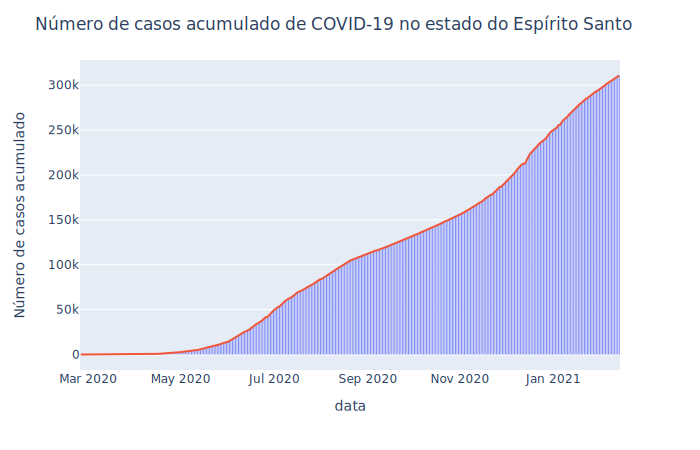

In [66]:
plot_st_linhas_barras( es_casos_acumulado,
    'data',
    'casosAcumulado',
    'data',
    'casosAcumulado',
    'data',
    'Número de casos acumulado',
    'Número de casos acumulado de COVID-19 no estado do Espírito Santo');

A série temporal do número de casos acumulado também nos mostra nova aceleração nos números a partir de Novembro.

#### Óbitos e média móvel

In [67]:
es_obitos_novos = es[['data', 'obitosNovos']]
es_obitos_novos['media_movel'] = es_obitos_novos['obitosNovos'].rolling(7).mean()

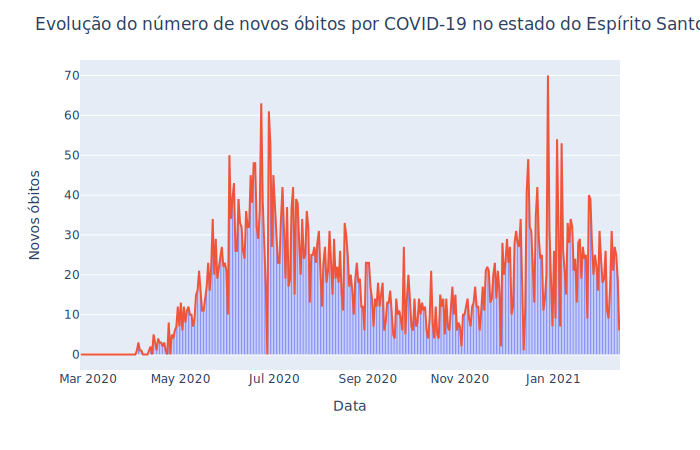

In [68]:
plot_st_linhas_barras(es_obitos_novos,
    'data',
    'obitosNovos',
    'data',
    'obitosNovos',
    'Data',
    'Novos óbitos',
    'Evolução do número de novos óbitos por COVID-19 no estado do Espírito Santo')

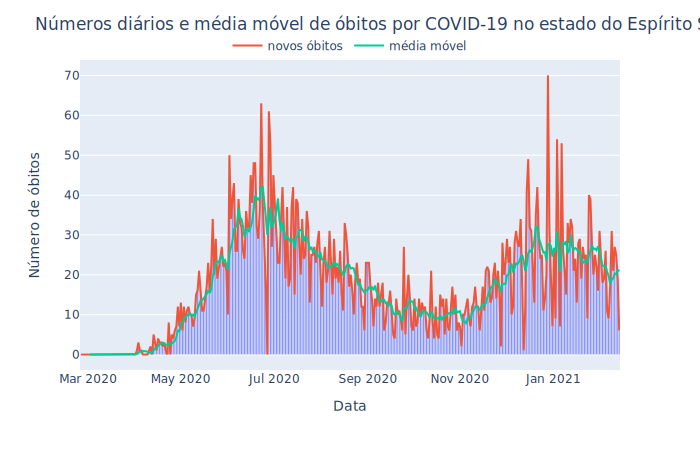

In [69]:
plot_st_com_media_movel(es_obitos_novos,
    'data',
    'obitosNovos',
    'data',
    'obitosNovos',
    'media_movel',
    'Data',
    'Número de óbitos',
    'novos óbitos',
   ' Números diários e média móvel de óbitos por COVID-19 no estado do Espírito Santo');

Em relação aos óbitos, a média móvel no estado do Espírito Santo também apresenta queda entre Junho e Novembro, com nova aceleração a partir do início desse mesmo mês.

A partir de 31/01/2021, houve um pouco mais de uma semana de queda nessa média, com nova tendência de alta nos últimos dias. A conferir se essa tendência se confirmará.

#### Taxa de mortalidade

In [70]:
es['taxaMortalidade'] = ((es['obitosAcumulado'] / es['casosAcumulado']) * 100).round(1)

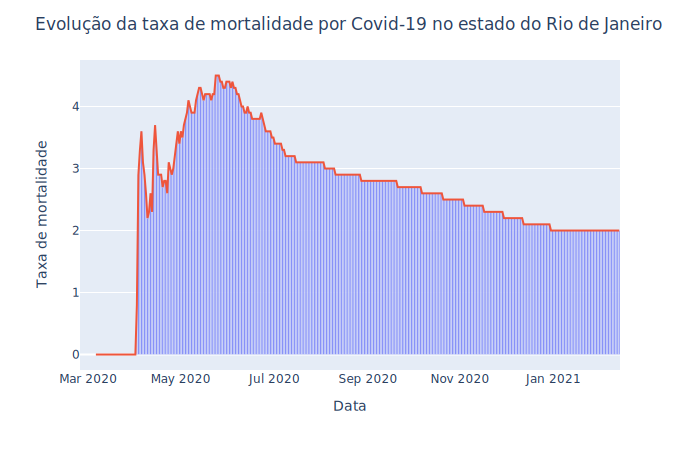

In [71]:
plot_st_linhas_barras(es, 'data', 'taxaMortalidade', 'data', 'taxaMortalidade', 'Data', 
                      'Taxa de mortalidade', 
                      'Evolução da taxa de mortalidade por Covid-19 no estado do Rio de Janeiro')

A taxa de mortalidade no estado do Espírito Santo se manteve em queda desde seu pico em 26/05/2020, sem, em nenhum momentoa partir daí, ter novo aumento significativo. Atualmente está em 2%.

#### Autocorrelação

Autocorrelação de novos casos diários

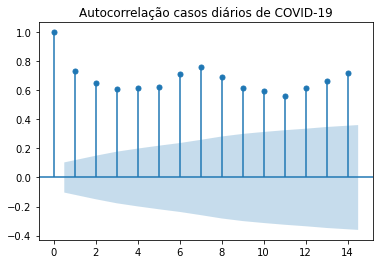

In [72]:
plot_acf(es_casos_novos['casosNovos'], lags = 14, title = 'Autocorrelação casos diários de COVID-19');

A autocorrelação dos novos casos de COVID no ES difere dos outros 2 estados analisados até agora (RJ e SP). Nesse caso, mantém-se uma correlação forte em todo o ciclo de 7 dias, com praticamente todos os lags chegando a 0.60.

Autocorrelação de óbitos diários

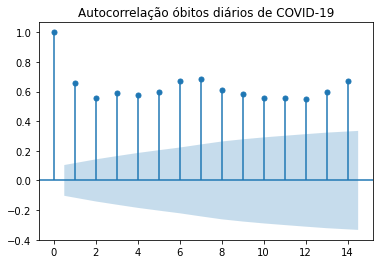

In [73]:
plot_acf(es_obitos_novos['obitosNovos'], lags = 14, title = 'Autocorrelação óbitos diários de COVID-19');

A autocorrelação dos novos óbitos diários por COVID também se mantém forte com os dias anteriores.

### MG

#### Novos casos e média móvel

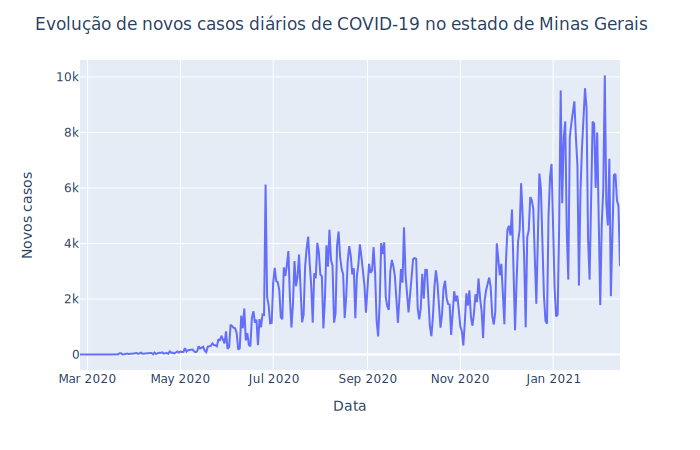

In [74]:
plot_st_linhas(mg, 'data', 'casosNovos', 'Data', 'Novos casos', 
               'Evolução de novos casos diários de COVID-19 no estado de Minas Gerais')

Média móvel:

In [75]:
mg_casos_novos = mg[['data', 'casosNovos']]
mg_casos_novos['media_movel'] = mg_casos_novos.casosNovos.rolling(7).mean()

C:\Users\Vinicius Moraes\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




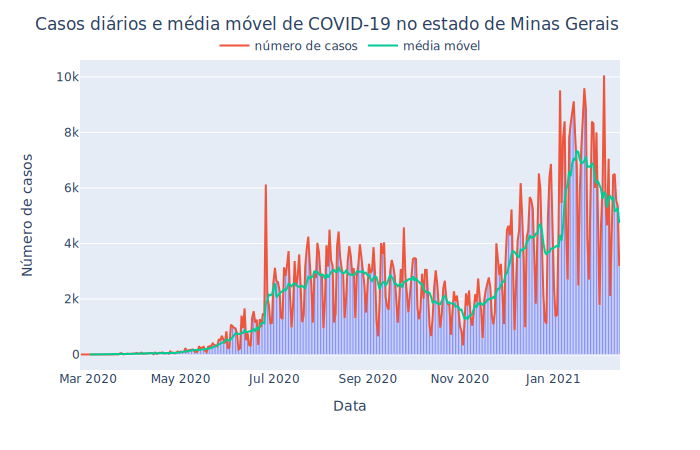

In [76]:
plot_st_com_media_movel(mg_casos_novos,'data','casosNovos','data','casosNovos','media_movel','Data',
                        'Número de casos','número de casos',
                        'Casos diários e média móvel de COVID-19 no estado de Minas Gerais');

A média móvel no número de novos casos de COVID-19 se manteve mais estável no estado de Minas Gerais entre o início da pandemia até o início de Novembro. A partir daí, houve uma forte aceleração até o dia 18/01/2021, onde se inicia uma desaceleração e forte tendência de que isso se mantenha durante as próximas semanas.

#### Número de casos acumulado

In [77]:
mg_casos_acumulado = mg[['data', 'casosAcumulado']]

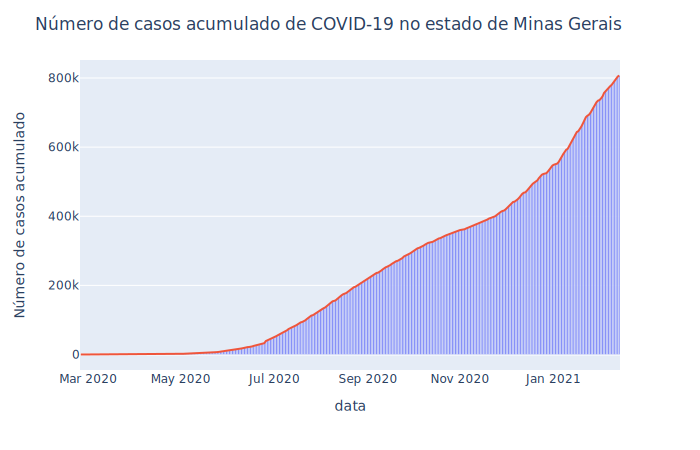

In [78]:
plot_st_linhas_barras( mg_casos_acumulado,
    'data',
    'casosAcumulado',
    'data',
    'casosAcumulado',
    'data',
    'Número de casos acumulado',
    'Número de casos acumulado de COVID-19 no estado de Minas Gerais');

#### Óbitos e média móvel

In [79]:
mg_obitos_novos = mg[['data', 'obitosNovos']]
mg_obitos_novos['media_movel'] = mg_obitos_novos['obitosNovos'].rolling(7).mean()

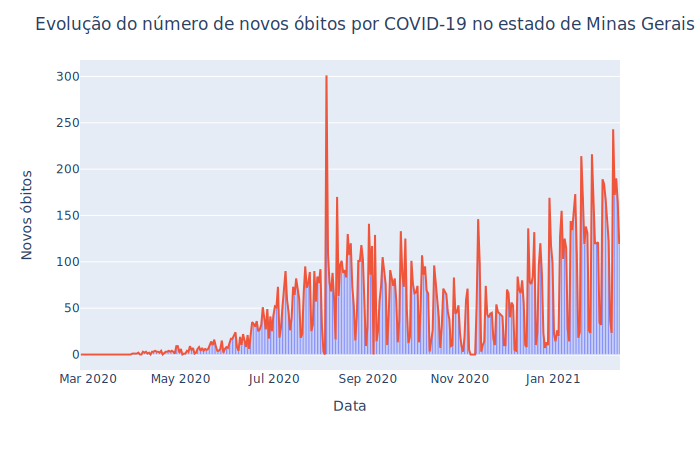

In [80]:
plot_st_linhas_barras(mg_obitos_novos,
    'data',
    'obitosNovos',
    'data',
    'obitosNovos',
    'Data',
    'Novos óbitos',
    'Evolução do número de novos óbitos por COVID-19 no estado de Minas Gerais')

Média móvel:

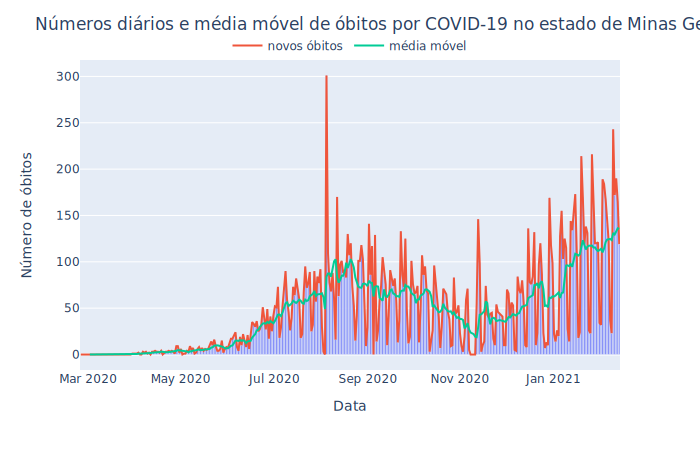

In [81]:
plot_st_com_media_movel(mg_obitos_novos,
    'data',
    'obitosNovos',
    'data',
    'obitosNovos',
    'media_movel',
    'Data',
    'Número de óbitos',
    'novos óbitos',
   ' Números diários e média móvel de óbitos por COVID-19 no estado de Minas Gerais');

O estadode Minas Gerais mantém tendência de aceleração na média móvel de óbitos por COVID-19 um pouco mais forte, assim como o estado do Rio de Janeiro. Lembrando que o Espírito Santo também possui tendência de alta nesses números, apesar de mais leve.

#### Taxa de mortalidade

In [82]:
mg['taxaMortalidade'] = ((mg['obitosAcumulado'] / mg['casosAcumulado']) * 100).round(1)

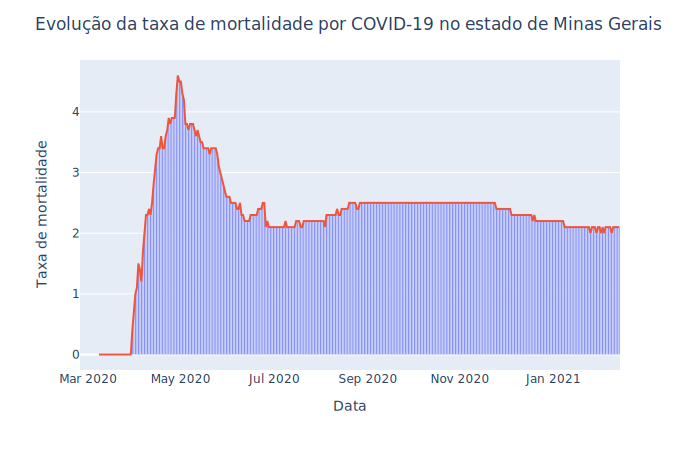

In [83]:
plot_st_linhas_barras(mg, 'data', 'taxaMortalidade', 'data', 'taxaMortalidade', 'Data', 
                      'Taxa de mortalidade', 
                      'Evolução da taxa de mortalidade por COVID-19 no estado de Minas Gerais')

Em relação à taxa de mortalidade, o estado de Minas Gerais apresentou aumento e permanência do índice após grande queda. Esse número só voltou a cair cerca de 2 meses depois.

#### Autocorrelação

Autocorrelação de novos casos diários

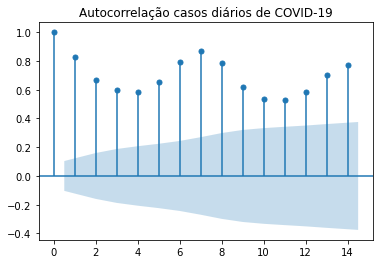

In [84]:
plot_acf(mg_casos_novos['casosNovos'], lags = 14, title = 'Autocorrelação casos diários de COVID-19');

Autocorrelação de óbitos diários

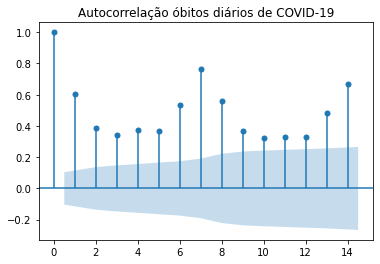

In [85]:
plot_acf(mg_obitos_novos['obitosNovos'], lags = 14, title = 'Autocorrelação óbitos diários de COVID-19');

### Comparações entre os 4 estados

#### Média móvel de novos casos

C:\Users\Vinicius Moraes\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




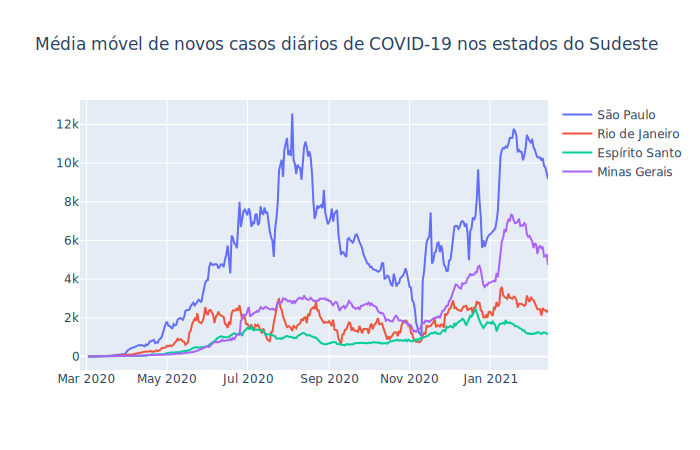

In [86]:
fig = go.Figure()
fig.add_trace(go.Line(x = sp_casos_novos['data'], y = sp_casos_novos['media_movel'], 
                      name = 'São Paulo'))
fig.add_trace(go.Line(x = rj_casos_novos['data'], y = rj_casos_novos['media_movel'], 
                      name = 'Rio de Janeiro'))
fig.add_trace(go.Line(x = es_casos_novos['data'], y = es_casos_novos['media_movel'], 
                      name = 'Espírito Santo'))
fig.add_trace(go.Line(x = mg_casos_novos['data'], y = mg_casos_novos['media_movel'], 
                      name = 'Minas Gerais'))
fig.update_layout(title = 'Média móvel de novos casos diários de COVID-19 nos estados do Sudeste')
fig.show()

Fazendo a comparação direta dos números diários de novos casos de COVID-19 entre os estados do Sudeste podemos perceber algumas peculiaridades:
* São Paulo teve uma aceleração mais acentuada do que os outros estados a partir de Junho, enquanto os outros se manteram de forma mais equilibrada. 
* Da mesma forma, São Paulo apresentou a queda mais acentuada nesses números até o início de Novembro
* o estado do Rio de Janeiro seguir o de São Paulo na forte aceleração a partir do fim de Dezembro

#### Média móvel nos números diários de óbitos

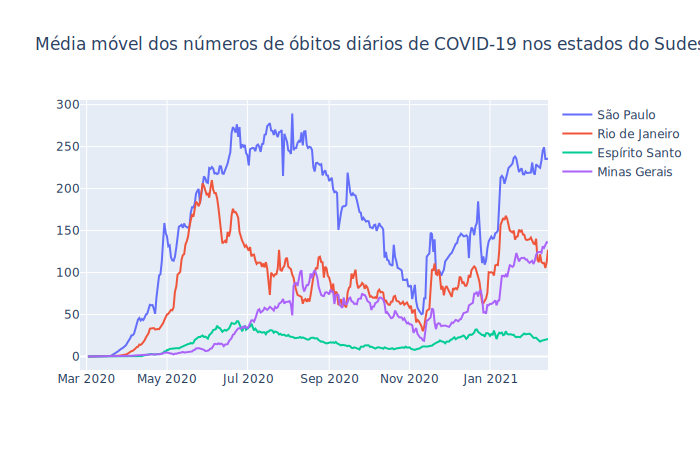

In [87]:
fig = go.Figure()
fig.add_trace(go.Line(x = sp_obitos_novos['data'], y = sp_obitos_novos['media_movel'], 
                      name = 'São Paulo'))
fig.add_trace(go.Line(x = rj_obitos_novos['data'], y = rj_obitos_novos['media_movel'], 
                      name = 'Rio de Janeiro'))
fig.add_trace(go.Line(x = es_obitos_novos['data'], y = es_obitos_novos['media_movel'], 
                      name = 'Espírito Santo'))
fig.add_trace(go.Line(x = mg_obitos_novos['data'], y = mg_obitos_novos['media_movel'], 
                      name = 'Minas Gerais'))
fig.update_layout(title = 'Média móvel dos números de óbitos diários de COVID-19 nos estados do Sudeste')
fig.show()

Algumas peculiaridades do gráfico de médias móveis dos novos óbitos por COVID-19 no Sudeste do país:
* Até o fim de Junho o Espírito Santo apresentou números diários de óbitos maiores do que o estado de Minas Gerais
* o estado do Rio de Janeiro manteve aceleração e números similares aos de São Paulo até o início de Junho
* apenas a média móvel de óbitos em São Paulo apresenta estabilidade nesse momento

#### Taxa de mortalidade

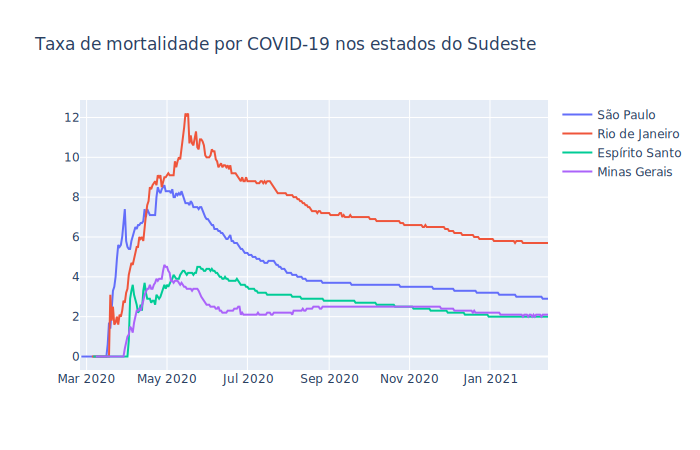

In [88]:
fig = go.Figure()
fig.add_trace(go.Line(x = sp['data'], y = sp['taxaMortalidade'], 
                      name = 'São Paulo'))
fig.add_trace(go.Line(x = rj['data'], y = rj['taxaMortalidade'], 
                      name = 'Rio de Janeiro'))
fig.add_trace(go.Line(x = es['data'], y = es['taxaMortalidade'], 
                      name = 'Espírito Santo'))
fig.add_trace(go.Line(x = mg['data'], y = mg['taxaMortalidade'], 
                      name = 'Minas Gerais'))
fig.update_layout(title = 'Taxa de mortalidade por COVID-19 nos estados do Sudeste')
fig.show()

No gráfico acima podemos perceber que a taxa de mortalidade no estado do Rio de Janeiro se manteve mais alta do que as dos outros estados do Sudeste durante a maior parte da pandemia, sendo mais que o dobro de Minas Gerais e Espírito Santo e quase o dobro de São Paulo.

# MODELOS DE PREVISÃO 

Nesse nosso trabalho de análise da séries temporais de COVID-19 podemos utilizar os dados passados para tentar prever os números de casos e de óbitos no futuro. Serão utilizados os modelo Prophet, AutoReg e Auto ARIMA para que sejam feitos testes de previsões dos novos casos e novos óbitos no Brasil.

Serão executados alguns passos para as previsões: teste de estacionariedade, utilização do modelo e avaliação da acurácia do mesmo. 

O prazo a ser previsto será de **31 dias**, entre os dias 15/01/20201 e 14/02/2021.

Para medirmos a acurácia dos modelos utilizaremos o módulo mean_squared_error, da biblioteca sklearn.

## Previsão: número de casos novos no Brasil

### Dados de treino e de teste

In [89]:
brasil.shape

(356, 18)

In [90]:
dados_treino_casos_brasil = brasil[['data', 'casosNovos']].loc[:324]
dados_teste_casos_brasil = brasil[['data', 'casosNovos']].loc[325:]

### Teste de estacionariedade

Já verificamos anteriomente que a variável que queremos prever é autocorrelacionada e parece possuir sazonalidade.

O próximo passo é verificarmos se a série temporal de novos casos é estacionária ou não-estacionária, pois, para fazer as previsões, precisamos que ela seja estacionária.

Séries que possuem tendência e sazonalidade são não estacionárias, pois não tem

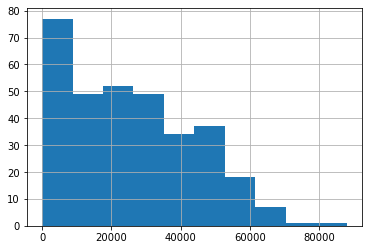

In [91]:
dados_treino_casos_brasil['casosNovos'].hist();

O histograma da variável de novos casos de COVID já nos dá um indício de que a sua série não é estacionária, pois não temos uma forma gaussiana na distribuição.

Mais uma forma de termos um indicativo da estacionariedade da série é dividindo a sua distribuição em algumas partes e verificando suas médiase variâncias. Caso variem, será mais um indício.

In [92]:
div = int(len(dados_treino_casos_brasil['casosNovos']) / 2)

x = dados_treino_casos_brasil['casosNovos'].values

p1, p2 = x[0:div], x[div:]

print('Média p1: ', p1.mean())
print('Média p2: ', p2.mean())
print('Variância p1: ', p1.var())
print('Variância p2: ', p2.var())

Média p1:  17295.80864197531
Média p2:  33879.58895705522
Variância p1:  313285070.2905426
Variância p2:  255356578.03349766


Temos médias diferentes nas 2 metades da distribuição dos dados. É mais um indício de não-estacionariedade da série.

Mas esses testes que fizemos pode ser considerados bastante "ingênuos". Sendo assim, temos outra forma mais sofisticada de verificar se a série é estacionária ou não estacionária: o **Augmented Dickey-Fuller (teste ADF)**.



In [93]:
teste_adf = adfuller(brasil['casosNovos'])
teste_adf

(-1.5149317748025737,
 0.526112297362276,
 17,
 338,
 {'1%': -3.449846029628477,
  '5%': -2.870129281376164,
  '10%': -2.5713460670144603},
 6981.104176663117)

In [94]:
p_valor = teste_adf[1]
print(f'P-valor: {p_valor}')

P-valor: 0.526112297362276


Como podemos perceber, a série temporal de novos casos de COVID-19 não é estacionária, pois o P-valor > 0,05.

Como visto anteriomente, a correlação nos mostra tendência na série temporal de novos casos.

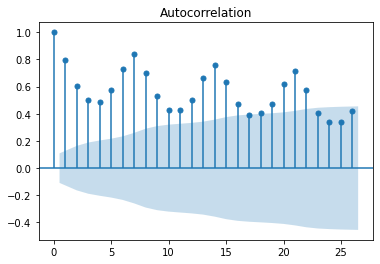

In [95]:
plot_acf(dados_treino_casos_brasil['casosNovos']);

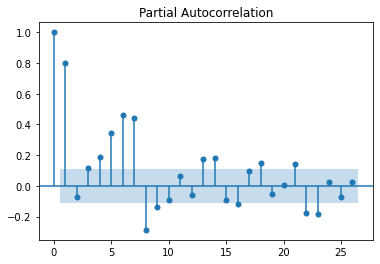

In [96]:
plot_pacf(dados_treino_casos_brasil['casosNovos']);

### Prophet

In [97]:
# criando o dataframe que conterá apenas a data e a a variável target
dic = {'data': 'ds', 'casosNovos': 'y'}
df = dados_treino_casos_brasil[['data', 'casosNovos']].rename(dic, axis = 1)

In [98]:
df.head()

,ds,y
0,2020-02-25,0
1,2020-02-26,1
2,2020-02-27,0
3,2020-02-28,0
4,2020-02-29,1


In [99]:
# instanciação do modelo
prophet = Prophet(seasonality_mode='multiplicative')

In [100]:
# o ajuste do modelo não precisa ser salvo em um objeto
prophet.fit(df) 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [101]:
# pontos a serem previstos
dados_teste_casos_brasil.shape

(31, 2)

In [102]:
futuro = prophet.make_future_dataframe(periods = 31, freq = 'D')
futuro.tail()

,ds
351,2021-02-10
352,2021-02-11
353,2021-02-12
354,2021-02-13
355,2021-02-14


In [103]:
previsao_prophet = prophet.predict(futuro)

In [104]:
previsao_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
351,2021-02-10,74640.431780,65108.331306,84271.223279
352,2021-02-11,75256.224273,65644.381586,84805.302952
353,2021-02-12,65806.941600,55684.569081,74927.247103
354,2021-02-13,60201.227939,50654.341099,69143.859206
355,2021-02-14,32873.605185,24378.408037,42166.122198


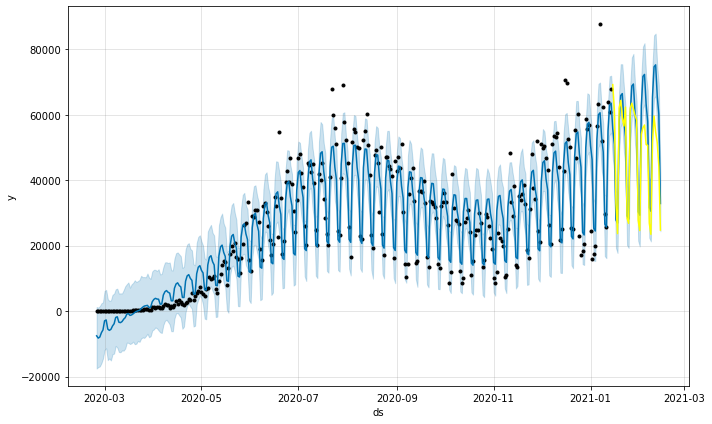

In [105]:
# daily
prophet.plot(previsao_prophet);
sns.lineplot(data = dados_teste_casos_brasil, x = 'data', y = 'casosNovos', color = 'yellow');

In [106]:
df_previsao_prophet_casos = pd.DataFrame(previsao_prophet.yhat.iloc[325:].values, 
                           index = dados_teste_casos_brasil.index)
df_previsao_prophet_casos.columns = ['previsao']
df_previsao_prophet_casos['valores_reais'] = dados_teste_casos_brasil['casosNovos'].values

**r2_score**

In [107]:
score_prophet_casos = r2_score(df_previsao_prophet_casos['valores_reais'], 
                            df_previsao_prophet_casos['previsao'])
score_prophet_casos

0.5949679396651045

### AutoReg

In [108]:
dados_treino_casos_brasil.set_index('data', inplace = True)
dados_teste_casos_brasil.set_index('data', inplace = True)

In [109]:
modelo_ajustado_autoreg = AutoReg(dados_treino_casos_brasil, lags = 14, trend = 'c', 
                                  seasonal=True, period=35).fit()

In [110]:
previsao_autoreg = modelo_ajustado_autoreg.predict(start = 325, end = 355)

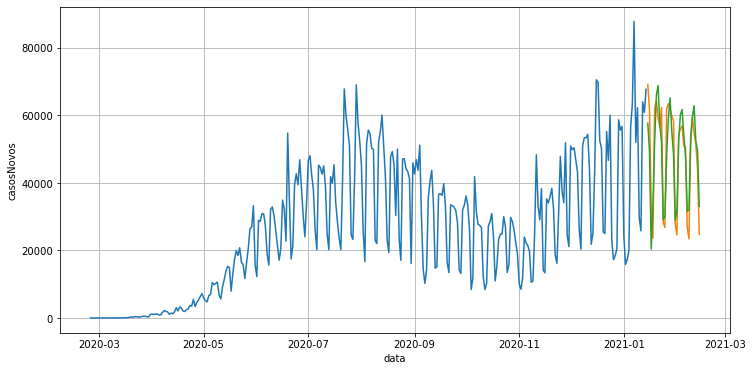

In [111]:
plt.figure(figsize = (12,6))
sns.lineplot(x = dados_treino_casos_brasil.index, y = dados_treino_casos_brasil['casosNovos'])
sns.lineplot(x = dados_teste_casos_brasil.index, y = dados_teste_casos_brasil['casosNovos'])
sns.lineplot(x = dados_teste_casos_brasil.index, y = previsao_autoreg)
plt.grid() 

In [112]:
df_auto_reg_casos = pd.DataFrame(previsao_autoreg.values, 
                           index = dados_teste_casos_brasil.index)
df_auto_reg_casos.columns = ['previsao']
df_auto_reg_casos['valores_reais'] = dados_teste_casos_brasil['casosNovos'].values

**r2_score**

In [113]:
score_autoreg_casos = r2_score(df_auto_reg_casos['valores_reais'], df_auto_reg_casos['previsao'])
score_autoreg_casos

0.7752379647664804

### Auto ARIMA

In [114]:
modelo_auto_arima = auto_arima(dados_treino_casos_brasil['casosNovos'].values,
                               error_action = 'ignore',
                              trace = True, seasonal=True, m = 13)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[13] intercept   : AIC=6958.361, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[13] intercept   : AIC=6994.340, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[13] intercept   : AIC=6986.933, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[13] intercept   : AIC=6946.790, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[13]             : AIC=6992.445, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[13] intercept   : AIC=6995.719, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[13] intercept   : AIC=6948.734, Time=0.37 sec
 ARIMA(0,1,1)(0,0,2)[13] intercept   : AIC=6948.535, Time=0.60 sec
 ARIMA(0,1,1)(1,0,0)[13] intercept   : AIC=6958.651, Time=0.17 sec
 ARIMA(0,1,1)(1,0,2)[13] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,1,0)(0,0,1)[13] intercept   : AIC=6983.364, Time=0.10 sec
 ARIMA(1,1,1)(0,0,1)[13] intercept   : AIC=6913.416, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[13] intercept   : AIC=6934.937, Time=0.14 sec
 ARIMA(1,1,1)(1,0,1)[13] intercept   : AIC=6913.896, Time=0.53 sec
 ARIMA(1,1,1)(0,0,2)[13]

In [115]:
previsao_auto_arima = modelo_auto_arima.predict(31)

In [116]:
df_auto_arima_casos = pd.DataFrame(previsao_auto_arima,
                             index = dados_teste_casos_brasil.index)
df_auto_arima_casos['valores_reais'] = dados_teste_casos_brasil.casosNovos
df_auto_arima_casos.columns = ['previsao', 'valores_reais']

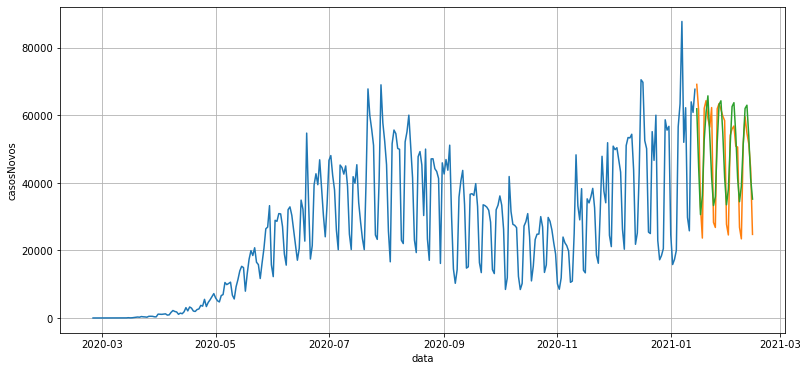

In [117]:
plt.figure(figsize = (13,6))
sns.lineplot(data = dados_treino_casos_brasil, x = dados_treino_casos_brasil.index, y = 'casosNovos')
sns.lineplot(data = df_auto_arima_casos, x = df_auto_arima_casos.index, y = 'valores_reais')
sns.lineplot(data = df_auto_arima_casos, x = df_auto_arima_casos.index, y = 'previsao');
plt.grid()

In [118]:
score_auto_arima_casos = r2_score(df_auto_arima_casos['valores_reais'], df_auto_arima_casos['previsao'])
score_auto_arima_casos

0.6397748295912056

### Comparação de performance dos modelos

**r2_score**

In [119]:
df_score_casos = pd.DataFrame([{'Prophet': score_prophet_casos, 'AutoReg': score_autoreg_casos, 
                              'Auto ARIMA': score_auto_arima_casos}]).T
df_score_casos.columns = ['R2 score']
df_score_casos = df_score_casos.sort_values('R2 score', ascending=False)
df_score_casos

,R2 score
AutoReg,0.775238
Auto ARIMA,0.639775
Prophet,0.594968


## Previsão: número de novos óbitos no Brasil

### Dados de treino e de teste

In [120]:
brasil.shape

(356, 18)

In [121]:
dados_treino_obitos_brasil = brasil[['data', 'obitosNovos']].loc[:324]
dados_teste_obitos_brasil = brasil[['data', 'obitosNovos']].loc[325:]

### Teste de estacionariedade

In [122]:
teste_adf = adfuller(brasil['obitosNovos'])
teste_adf

(-1.9153521894073242,
 0.3248737784942687,
 17,
 338,
 {'1%': -3.449846029628477,
  '5%': -2.870129281376164,
  '10%': -2.5713460670144603},
 4331.776345674447)

In [123]:
p_valor = teste_adf[1]
print(f'P-valor: {p_valor}')

P-valor: 0.3248737784942687


Como podemos observar acima, a série temporal de novos registros de óbito por COVID-19 no Brasil NÃO é estacionária.

### Prophet

In [124]:
# criando o dataframe que conterá apenas a data e a a variável target
dic = {'data': 'ds', 'obitosNovos': 'y'}
df = dados_treino_obitos_brasil[['data', 'obitosNovos']].rename(dic, axis = 1)

In [125]:
# instanciação do modelo
prophet = Prophet(seasonality_mode='multiplicative')

In [126]:
# o ajuste do modelo não precisa ser salvo em um objeto
prophet.fit(df) 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [127]:
futuro = prophet.make_future_dataframe(periods = 31, freq = 'D')

In [128]:
previsao_prophet = prophet.predict(futuro)

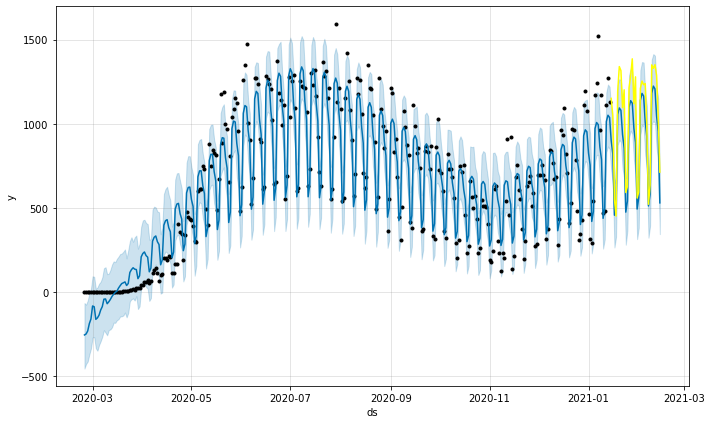

In [129]:
prophet.plot(previsao_prophet);
sns.lineplot(data = dados_teste_obitos_brasil, x = 'data', y = 'obitosNovos', color = 'yellow');

In [130]:
df_previsao_prophet_obitos = pd.DataFrame(previsao_prophet.yhat.iloc[325:].values, 
                           index = dados_teste_obitos_brasil.index)
df_previsao_prophet_obitos.columns = ['previsao']
df_previsao_prophet_obitos['valores_reais'] = dados_teste_obitos_brasil['obitosNovos'].values

In [131]:
score_prophet_obitos = r2_score(df_previsao_prophet_obitos['valores_reais'], 
                                df_previsao_prophet_obitos['previsao'])
score_prophet_obitos

0.6749151698147369

### AutoReg

In [132]:
dados_treino_obitos_brasil.set_index('data', inplace = True)
dados_teste_obitos_brasil.set_index('data', inplace = True)

In [133]:
modelo_ajustado_autoreg = AutoReg(dados_treino_obitos_brasil, lags = 21, trend = 'c', 
                                  seasonal=True, period=35).fit()

In [134]:
previsao_autoreg = modelo_ajustado_autoreg.predict(start = 325, end = 355)

C:\Users\Vinicius Moraes\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




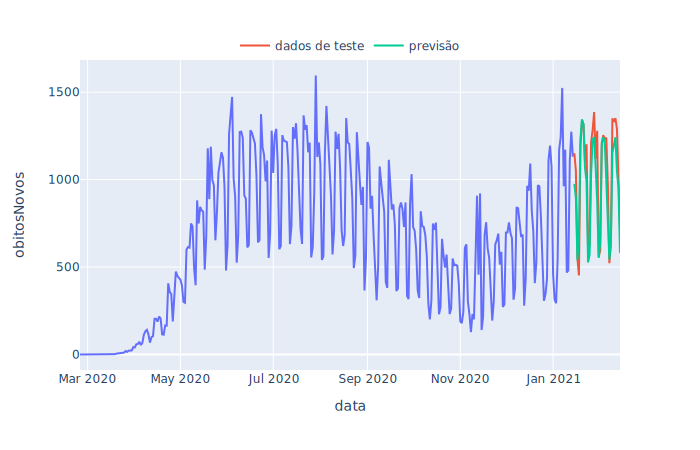

In [135]:
fig = px.line(data_frame = dados_treino_obitos_brasil, x = dados_treino_obitos_brasil.index, 
              y = 'obitosNovos')
fig.add_trace(go.Line(x = dados_teste_obitos_brasil.index, y = dados_teste_obitos_brasil['obitosNovos'], 
                      showlegend = True, name = 'dados de teste'))
fig.add_trace(go.Line(x = dados_teste_obitos_brasil.index, y = previsao_autoreg, 
                      showlegend = True, name = 'previsão'))
fig.update_layout(legend=dict(
                      title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"))
fig.show()

In [136]:
df_predicao_auto_reg_obitos = pd.DataFrame(previsao_autoreg.values, 
                           index = dados_teste_obitos_brasil.index)
df_predicao_auto_reg_obitos.columns = ['previsao']
df_predicao_auto_reg_obitos['valores_reais'] = dados_teste_obitos_brasil['obitosNovos'].values

In [137]:
score_autoreg_obitos = r2_score(df_predicao_auto_reg_obitos['valores_reais'], 
                         df_predicao_auto_reg_obitos['previsao'])
score_autoreg_obitos

0.7853575533471889

### Auto ARIMA

In [138]:
modelo_auto_arima = auto_arima(dados_treino_obitos_brasil['obitosNovos'].values,
                               error_action = 'ignore',
                              trace = True, seasonal=True, m = 7)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4524.979, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4265.048, Time=0.79 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4352.626, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4523.038, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=4526.868, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=4224.929, Time=0.91 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=4195.277, Time=0.84 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=4193.397, Time=0.55 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=4401.721, Time=0.17 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=4195.256, Time=0.75 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=4348.945, Time=0.33 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=4240.641, Time=0.77 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=4

In [139]:
previsao_auto_arima = modelo_auto_arima.predict(31)

In [140]:
df_auto_arima_obitos = pd.DataFrame(previsao_auto_arima,
                             index = dados_teste_obitos_brasil.index)
df_auto_arima_obitos['valores_reais'] = dados_teste_obitos_brasil.obitosNovos
df_auto_arima_obitos.columns = ['previsao', 'valores_reais']

C:\Users\Vinicius Moraes\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




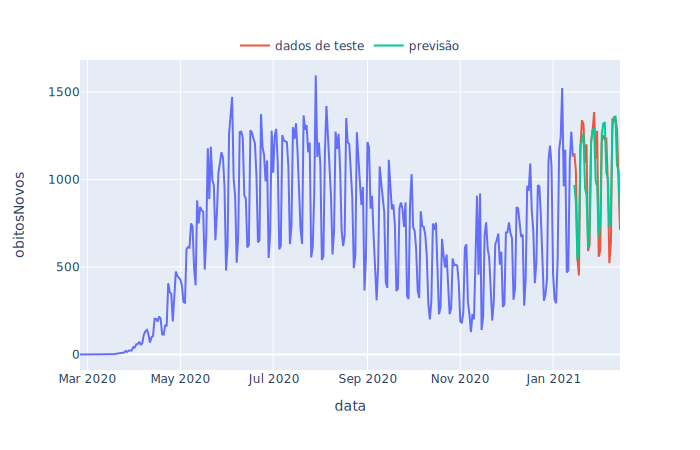

In [141]:
fig = px.line(data_frame = dados_treino_obitos_brasil, x = dados_treino_obitos_brasil.index, 
              y = 'obitosNovos')
fig.add_trace(go.Line(x = df_auto_arima_obitos.index, y = df_auto_arima_obitos['valores_reais'], 
                      showlegend = True, name = 'dados de teste'))
fig.add_trace(go.Line(x = df_auto_arima_obitos.index, y = df_auto_arima_obitos['previsao'], 
                      showlegend = True, name = 'previsão'))
fig.update_layout(legend=dict(
                      title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"))
fig.show()

In [142]:
score_auto_arima_obitos = r2_score(df_auto_arima_obitos['valores_reais'], df_auto_arima_obitos['previsao'])
score_auto_arima_obitos

0.8022257917426144

### Comparação de performance dos modelos

In [143]:
df_comparacao_obitos = pd.DataFrame([{'Prophet': score_prophet_obitos, 'AutoReg': score_autoreg_obitos, 
                              'Auto ARIMA': score_auto_arima_obitos}]).T
df_comparacao_obitos.columns = ['R2 score']
df_comparacao_obitos = df_comparacao_obitos.sort_values('R2 score', ascending=False)
df_comparacao_obitos

,R2 score
Auto ARIMA,0.802226
AutoReg,0.785358
Prophet,0.674915


# CONSIDERAÇÕES FINAIS

<ins>**Análises:**</ins>

Com as análises feitas nos dados de COVID-19 até o dia 14/02/2021 percebemos que os eventos de fim de ano fizeram o país voltar a sofrer fortemente com a doença causada pelo Coronavírus. Podemos perceber que uma há, infelizmente, espaço para alta nas transmissões e óbitos, vistos que os novos números continuam a explodir diariamente.

<ins>**Modelos de previsão:**</ins>

Nessa análise utilizamos 3 modelos para fazer as previsões e comparar suas eficácias: Prophet, AutoReg e Auto ARIMA.

Lembrando que não foi feito nenhum tipo de diferenciação para suavizar os dados e nãp foram experimentados todos os parâmetros oferecidos por cada modelo.

Apresentados e testados alguns parâmetros para obter o melhor resultado de cada modelo, obtivemos os seguintes resultados para testar a previsão de novos números de óbitos por COVID-19, com período de 31 dias:

In [144]:
df_comparacao_obitos

,R2 score
Auto ARIMA,0.802226
AutoReg,0.785358
Prophet,0.674915


Já para teste de previsão de novos casos de COVID-19, também com período de 31 dias, obtivemos os seguintes scores:

In [145]:
df_score_casos

,R2 score
AutoReg,0.775238
Auto ARIMA,0.639775
Prophet,0.594968


Com os estudos divulgados recentemente em várias partes do mundo, a vacinação é a maior esperança para que esses números alarmantes de casos e óbitos por COVID-19 voltem a cair. Há países com vacinação avançada e com números cada vez menores em relação à doença, enquanto o Brasil ainda se arrasta nesse sentido.

Além disso, temos as novas variantes que parecem começar a influenciar nesses números. Devemos ficar atentos para avaliarmos sua evolução nas próximas semanas.